In [1]:
import random
import os, math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gaussian_kde, ks_1samp, uniform
from utils import *

plt.rcParams["font.family"] = "DejaVu Serif"    

plt.rcParams.update({
    "font.size": 14,          
    "axes.titlesize": 16,     
    "axes.labelsize": 14,     
    "xtick.labelsize": 12,    
    "ytick.labelsize": 12,
    "legend.fontsize": 12,    
    "figure.titlesize": 18,   
})


SEED = 400
random.seed(SEED)
np.random.seed(SEED)

## Gaussian mean shift

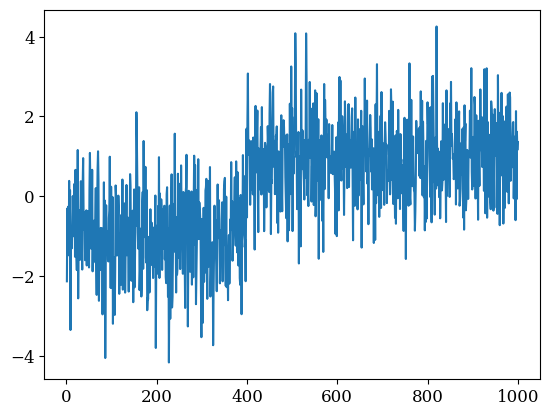

In [2]:
n = 1000; xi = 400

timeseries = np.concatenate([np.random.normal(-1, 1, xi), np.random.normal(1, 1, n - xi)])
time_indices = np.arange(1, n + 1)

plt.plot(time_indices, timeseries)
plt.show()

## MCP changepoint localization

In [3]:
def compute_p_value_for_t(t, n, timeseries, left_scores, right_scores):
    """Compute p-value for a single time point t"""
    p_values_curr = np.zeros(n)
    
    for r in range(t+1):
        left_segment_scores = left_scores[:r+1]
        rank = np.sum(left_scores[r] < left_segment_scores) + np.random.uniform(0, 1) * np.sum(left_scores[r] == left_segment_scores)
        p_values_curr[r] = rank / (r + 1)
    
    for r in range(n-1, t, -1):
        right_segment_scores = right_scores[r:]
        rank = np.sum(right_scores[r] < right_segment_scores) + np.random.uniform(0, 1) * np.sum(right_scores[r] == right_segment_scores)
        p_values_curr[r] = rank / (n - r + 1)
    
    p_left = ks_1samp(p_values_curr[:t+1], uniform.cdf, method="exact")[1]
    p_right = ks_1samp(p_values_curr[t+1:], uniform.cdf, method="exact")[1]

    # raw KS distance (D statistic)
    D_left = ks_1samp(p_values_curr[:t+1], uniform.cdf, method="exact").statistic
    D_right = ks_1samp(p_values_curr[t+1:], uniform.cdf, method="exact").statistic

    
    return 1 - (1 - min(p_left, p_right)) ** 2

def run_single_simulation(data):
    f_0 = norm(-1, 1)
    f_1 = norm(1, 1)

    n=len(data)

    left_scores = f_1.pdf(data) / f_0.pdf(data)
    right_scores = f_0.pdf(data) / f_1.pdf(data)

    # Parallelize the outer loop over t
    p_values = Parallel(n_jobs=-1, verbose=1)(
        delayed(compute_p_value_for_t)(t, n, data, left_scores, right_scores) 
        for t in range(n-1)
    )
    
    return np.array(p_values)

p_values_mcp = run_single_simulation(timeseries)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 960 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 999 out of 999 | elapsed:    2.3s finished


## CPP scores

#### oracle scores

In [4]:
def weighted_mean_score(x, t):
    
    x = np.asarray(x, dtype=float); n = x.shape[0]
    
    idx = np.arange(n, dtype=float)
    w = 1-np.abs(idx - t) / n
    w = np.clip(w, 0.0, None)  

    w1 = w[:t]; x1 = x[:t]; s1 = w1.sum()
    m_left = (x1 @ w1) / s1 if s1 > 0 else 0.0

    w2 = w[t:]; x2 = x[t:]; s2 = w2.sum()
    m_right = (x2 @ w2) / s2 if s2 > 0 else 0.0
        
    return float(abs(m_left - m_right))


def oracle_loglik_score(x, t, mu0=-1.0, mu1=1.0, sigma=1.0):
    
    x = np.asarray(x); n = x.size

    logf0 = norm.logpdf(x, loc=mu0, scale=sigma)
    logf1 = norm.logpdf(x, loc=mu1, scale=sigma)

    csum = np.cumsum(logf0 - logf1)          

    t_hat = np.argmax(csum)             
    
    return csum[t-1] - csum[t_hat]

#### learned log-likelihood ratio scores

In [5]:
def par_learned_loglik_score(x, t):
    
    x = np.asarray(x, dtype=float).reshape(-1)
    n = x.size
    
    # Prefix sums
    S = np.cumsum(x)
    Q = np.cumsum(x * x)
    S_total, Q_total = S[-1], Q[-1]

    t_vals = np.arange(1, n)
    num_Left, num_Right = t_vals, n - t_vals
    S_Left, Q_Left = S[t_vals - 1], Q[t_vals - 1]
    S_Right, Q_Right = S_total - S_Left, Q_total - Q_Left

    # log-likelihood ratio function
    LLR = -0.5 * ((Q_Left - (S_Left**2)/num_Left) + (Q_Right - (S_Right**2)/num_Right))

    t_hat = int(np.argmax(LLR))  
    return float(LLR[t - 1] - LLR[t_hat])

In [6]:
import numpy as np
from scipy.stats import norm, gaussian_kde

def kde_learned_loglik_score(x, t, eps=1e-12, fallback_scale=0.05):
    x = np.asarray(x, float).ravel()
    n = x.size

    def fit(arr):
        arr = np.asarray(arr, float).ravel()
        if arr.size <= 1:
            m = arr[0] if arr.size == 1 else 0.0
            return lambda y, m=m: norm.pdf(y, loc=m, scale=fallback_scale)
        return gaussian_kde(arr)

    # --- updated split logic ---
    if t < 25:
        kl, kr = fit(x[:25]), fit(x[25:])
    elif t > n - 25:
        kl, kr = fit(x[:n-25]), fit(x[n-25:])
    else:
        kl, kr = fit(x[:t]), fit(x[t:])
    # ---------------------------

    logL = np.log(np.maximum(np.asarray(kl(x)), eps))
    logR = np.log(np.maximum(np.asarray(kr(x)), eps))

    # LL[s-1] = sum_{i< s} logL[i] + sum_{i>= s} logR[i]  for s=1..n-1
    LL = np.cumsum(logL)[:-1] + np.cumsum(logR[::-1])[::-1][1:]

    return float(LL[t-1] - LL[np.argmax(LL)])


## CONCH p-values

In [7]:
## CPP score = weighted mean difference
p_values_conch_weighted_mean = compute_p_values(
    timeseries,
    score_fn=weighted_mean_score,
    nperm=300,
    random_state=42,
    n_jobs=-1,         
    backend="loky",    
    verbose=10,  
)

computing CONCH p-values:   0%|          | 0/999 [00:00<?, ?it/s]

In [8]:
## CPP score = oracle log likelihood ratio
p_values_conch_orcl_loglike = compute_p_values(
    timeseries,
    score_fn=oracle_loglik_score,
    nperm=300,
    random_state=42,
    n_jobs=-1,         
    backend="loky",   
    verbose=10,       
)

computing CONCH p-values:   0%|          | 0/999 [00:00<?, ?it/s]

In [9]:
## CPP score = (parametrically) learned log-likelihood ratio
p_values_conch_par_learned_loglike = compute_p_values(
    timeseries,
    score_fn=par_learned_loglik_score,
    nperm=300,
    random_state=42,
    n_jobs=-1,         
    backend="loky",    
    verbose=10,      
)

computing CONCH p-values:   0%|          | 0/999 [00:00<?, ?it/s]

In [10]:
## CPP score = (non-parametrically) learned log-likelihood ratio
p_values_conch_npar_learned_loglike = compute_p_values(
    timeseries,
    score_fn=kde_learned_loglik_score,
    nperm=300,
    random_state=42,
    n_jobs=-1,         
    backend="loky",    
    verbose=10,      
)

computing CONCH p-values:   0%|          | 0/999 [00:00<?, ?it/s]

## performance comparison: set length and $p$-value plot

In [11]:
print(f"CI: {confidence_set(p_values_mcp, 0.05)}")
print(f"CI: {confidence_set(p_values_conch_weighted_mean, 0.05)}")
print(f"CI: {confidence_set(p_values_conch_orcl_loglike, 0.05)}")
print(f"CI: {confidence_set(p_values_conch_par_learned_loglike, 0.05)}")
print(f"CI: {confidence_set(p_values_conch_npar_learned_loglike, 0.05)}")

CI: [365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430]
CI: [385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408]
CI: [397, 398, 400]
CI: [397, 398, 400]
CI: [397, 398, 400]


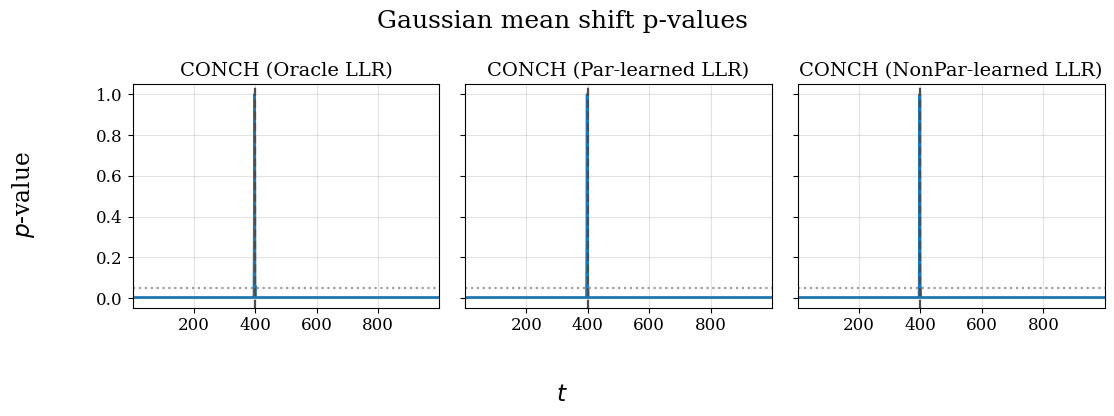

Saved panel figure to:
  ../images/gaussian_mean_shift_pvalues_slides.pdf


In [13]:
# --- Configurable choices ---
alpha = 0.05
xi = int(xi)  # ensure int

# Choose which series to plot by label (exact match) or leave as None/[] to plot all
include = [
    # "CONCH (Weighted mean)",
    # "CONCH (Oracle LLR)",
    # "CONCH (Par-learned LLR)",
    # "CONCH (NonPar-learned LLR)",
    # "MCP localization",
]
exclude = [
    "CONCH (Weighted mean)",
     "MCP localization",
]

# Layout & styling controls
ncols = None          # e.g., set to 3 to wrap across rows
sharey = True         # False => each panel gets its own y-scale
tight_ylim = False    # True => each panel tightens y-lims to its curve
line_width = 2.0
line_color = None     # None => use Matplotlib's default blue; or set e.g. "#1f77b4"

# --- Data series ---
series = [
    ("CONCH (Weighted mean)",      p_values_conch_weighted_mean),
    ("CONCH (Oracle LLR)",         p_values_conch_orcl_loglike),
    ("CONCH (Par-learned LLR)",    p_values_conch_par_learned_loglike),
    ("CONCH (NonPar-learned LLR)", p_values_conch_npar_learned_loglike),
    ("MCP localization",           p_values_mcp),
]

# ---------------- Plotting ----------------
# Filter series per user's selection
if include and exclude:
    raise ValueError("Use either include or exclude, not both.")
if include:
    selected = [(lbl, pv) for (lbl, pv) in series if lbl in include]
else:
    selected = [(lbl, pv) for (lbl, pv) in series if lbl not in set(exclude)]

if not selected:
    raise ValueError("No series selected to plot. Check `include`/`exclude` labels.")

# Resolve default blue from current rcParams if color not provided
if line_color is None:
    try:
        line_color = plt.rcParams["axes.prop_cycle"].by_key()["color"][0]  # default blue for current style
    except Exception:
        line_color = "#1f77b4"  # fallback to classic Matplotlib blue

# Layout
k = len(selected)
if ncols is None:
    ncols = k  # all in one row
nrows = int(np.ceil(k / ncols))

# Figure size scales with number of panels
panel_w = 3.5
panel_h = 3.4
fig_w = panel_w * ncols + 1.0
fig_h = panel_h * nrows + 1.0

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_w, fig_h), sharey=sharey)
if k == 1:
    axes = np.array([axes])  # ensure iterable shape
axes = axes.ravel()

# Global x-limit based on the longest series among the *selected*
max_len = max(len(pv) for _, pv in selected)

for i, (label, pvals) in enumerate(selected):
    ax = axes[i]
    t = np.arange(1, len(pvals) + 1)

    # single curve per panel, always default blue
    ax.plot(t, pvals, color=line_color, lw=line_width)

    # changepoint & threshold (neutral greys)
    ax.axvline(x=xi, ls="--", color="#4D4D4D", lw=1.6)
    ax.axhline(y=alpha, ls=":",  color="#9E9E9E", lw=1.6)

    # axes cosmetics
    ax.set_xlim(1, max_len)  # align panels on the same x-axis
    if tight_ylim and len(pvals):
        ymin = min(np.min(pvals), alpha)
        ymax = max(np.max(pvals), alpha)
        pad = 0.03 * (ymax - ymin if ymax > ymin else 1.0)
        ax.set_ylim(max(0.0, ymin - pad), min(1.0, ymax + pad))
    ax.grid(True, alpha=0.35)

    # small, uncluttered panel title
    ax.set_title(label,fontsize = 14)

# Remove any empty axes if grid > selected count
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Shared labels and title
fig.supxlabel(r"$t$", y=0.02)
fig.supylabel(r"$p$-value", x=0.02)
fig.suptitle("Gaussian mean shift p-values", y=0.92)

plt.tight_layout(rect=[0.035, 0.035, 0.99, 0.95])

# Save
outdir = os.path.join("..", "images")
os.makedirs(outdir, exist_ok=True)
pdf_path = os.path.join(outdir, "gaussian_mean_shift_pvalues_slides.pdf")
fig.savefig(pdf_path, bbox_inches="tight")
plt.show()
plt.close(fig)

print(f"Saved panel figure to:\n  {pdf_path}")
